# Analyze result
モデルの予測性能などを評価するノートブック

In [28]:
%load_ext autoreload
%autoreload 2

In [30]:
import torch
import os
import csv 
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from src.score_prediction_models.docking_score_predictor import DockingScorePredictor
from src.data.dataloader import get_dataloader
from tqdm.notebook import tqdm
from matplotlib import cm

In [41]:
with open('../config/filepath.yml') as file:
    path_config = yaml.safe_load(file)

with open('../config/model.yml') as file:
    model_config = yaml.safe_load(file)

with open('../config/data.yml') as file:
    data_config = yaml.safe_load(file)

dude_dir = os.path.join('..', path_config['data']['DUD-E'])
alphafold_dir = os.path.join('..', path_config['data']['alphafold'])
smiles_dir = os.path.join('..', path_config['data']['smiles'])
output_dir = os.path.join('..', path_config['data']['plots'])
hist_dir = os.path.join('..', path_config['data']['hist'])
eval_dir = os.path.join('..', path_config['data']['eval'])
preprocessed_dir = os.path.join('..', path_config['data']['preprocessed'])
sample_dir = os.path.join('..', path_config['data']['samples'])
model_dir = os.path.join('..', path_config['data']['docking'])

ds_reg_output_dir = os.path.join(output_dir, 'ds_regression')



In [33]:
model_timestamp = '2024-12-23_14-28-07'
result_test_path = os.path.join(eval_dir, 'ds_regression', f"results_{model_timestamp}_test.csv")
result_train_path = os.path.join(eval_dir, 'ds_regression', f"results_{model_timestamp}_train.csv")

result_test_df = pd.read_csv(result_test_path)
result_train_df = pd.read_csv(result_train_path)

print(result_test_df.head())
print(result_train_df.head())

                                              SMILES Protein_ID  \
0  C[NH+](C)[C@H](CNC(=O)NNC(=O)c1cc(Br)c[nH]1)c1...        DYR   
1  Cc1ccc(-c2c[nH]nc2[C@@H]2CCCN(C(=O)C3([NH3+])C...        DYR   
2    C[C@@]12CC[C@H]3C[C@]1(C(=O)[O-])[NH2+]C[C@]32C        DYR   
3  C/C(=N/NC(=O)c1cc(O)ccc1O)c1cccc(NC(=O)c2csc3c...        DYR   
4        CS[C@H](C)/C([O-])=N/S(=O)(=O)c1cc(Br)ccc1C       ALDR   

   Actual_Docking_Score  Predicted_Docking_Score  
0             -6.285899                -2.109682  
1             -6.315050                -3.582389  
2             -5.237497                -2.624921  
3             -6.261746                -3.818731  
4             -7.496721                -6.190664  
                                              SMILES Protein_ID  \
0  Cc1c(C(=O)Nc2cc(C(F)(F)F)ccc2Cl)oc2c1/C(=N/NC(...       CDK2   
1    O=C(N/N=C/c1cccc(Br)c1)c1nn(Cc2ccc(Cl)cc2)cc1Br       DHI1   
2       CCCc1cc([O-])nc(SCC(=O)NCc2ccccc2Cn2cccn2)n1      CASP3   
3  NC(=O)[C@@H]1CCCN1C(

In [43]:
def plot_docking_scores_vs_predictions(df, output_dir, filename="docking_score_plot.png"):
    """
    Plots docking score predictions vs actual values with color coding for Protein IDs.

    Args:
        df (pd.DataFrame): DataFrame containing columns 'Protein_ID', 'Actual_Docking_Score', and 'Predicted_Docking_Score'.
        output_dir (str): Directory to save the plot.
        filename (str): Name of the output plot file. Defaults to 'docking_score_plot.png'.

    Saves:
        A scatter plot as a file in the specified directory.
    """
    # Unique Protein IDs and color map
    unique_protein_ids = df['Protein_ID'].unique()
    cmap = cm.get_cmap('tab10', len(unique_protein_ids))
    colors = {protein_id: cmap(i) for i, protein_id in enumerate(unique_protein_ids)}

    # Create the plot
    plt.figure(figsize=(10, 6))
    for protein_id in unique_protein_ids:
        subset = df[df['Protein_ID'] == protein_id]
        plt.scatter(
            subset["Actual_Docking_Score"],
            subset["Predicted_Docking_Score"],
            label=protein_id,
            color=colors[protein_id],
            alpha=0.7
        )

    # Add diagonal lines
    plt.axline((0, 0), slope=1, color="red", linestyle="--", label="y = x")
    plt.axline((0, 0.5), slope=1, color="gray", linestyle="--", alpha=0.5, label="y = x + 0.5")
    plt.axline((0, -0.5), slope=1, color="gray", linestyle="--", alpha=0.5, label="y = x - 0.5")

    # Labels, title, and legend
    plt.xlabel("Actual Docking Score")
    plt.ylabel("Predicted Docking Score")
    plt.title("Docking Score Prediction vs Actual Values")
    plt.legend(title="Protein ID")
    plt.grid(True)

    # Save the plot
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_file = os.path.join(output_dir, filename)
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")

    # Display the plot
    plt.show()

テストデータの予測値と実際の値をプロット

/tmp/ipykernel_773/1450284897.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/docking_score_test_plot.png


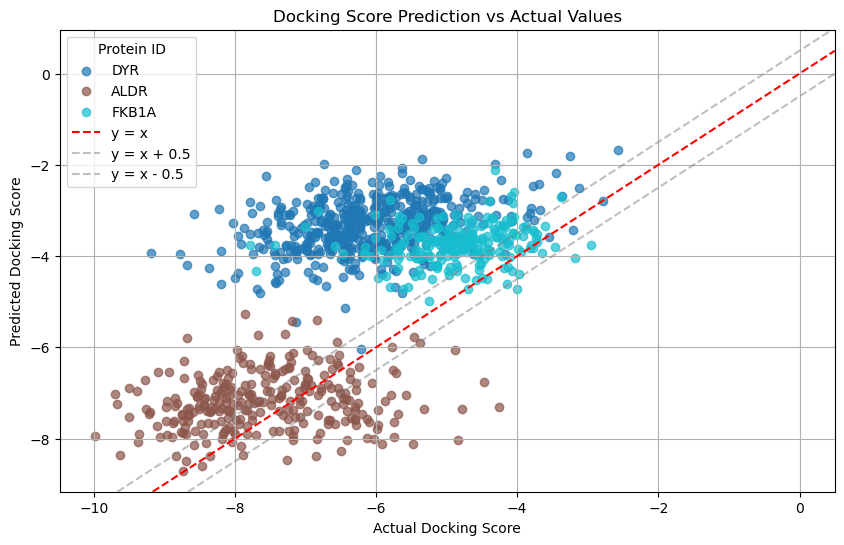

In [44]:
plot_docking_scores_vs_predictions(result_test_df, ds_reg_output_dir, filename="docking_score_test_plot.png")

相関係数と r2 値を計算

In [46]:
correration = result_test_df["Actual_Docking_Score"].corr(result_test_df["Predicted_Docking_Score"])
print(f"Correlation: {correration}")
r2 = r2_score(result_test_df["Actual_Docking_Score"], result_test_df["Predicted_Docking_Score"])
print(f"R2 Score: {r2}")

Correlation: 0.6114586839120323
R2 Score: -1.7617143142783953


学習データの予測値と実際の値をプロット

/tmp/ipykernel_773/1450284897.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/docking_score_train_plot.png


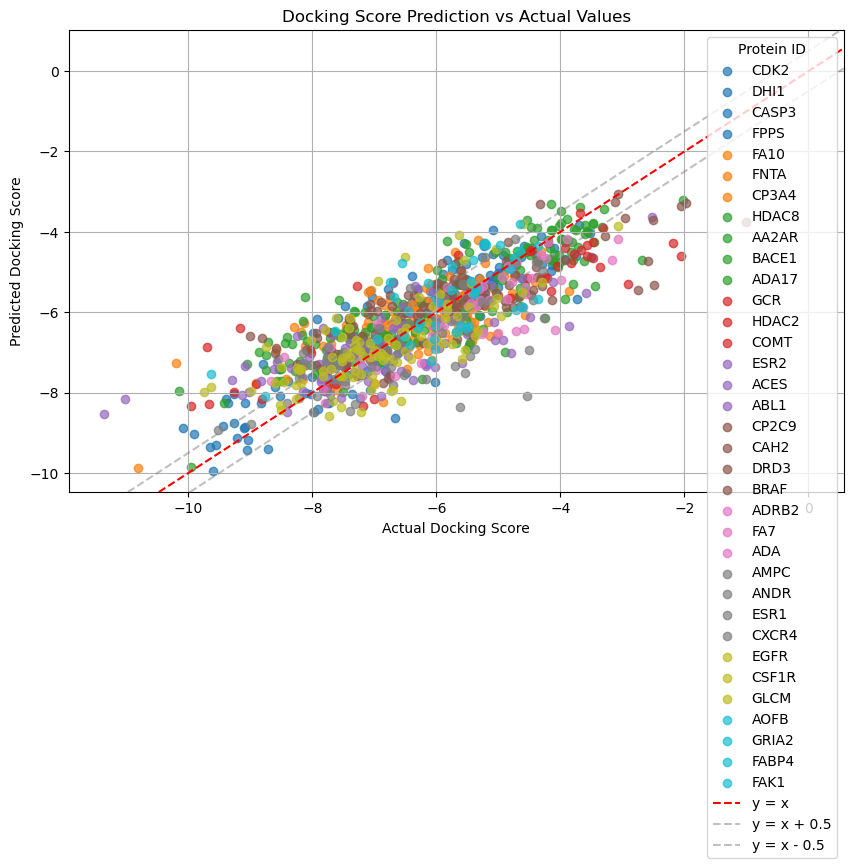

In [47]:
plot_docking_scores_vs_predictions(result_train_df, ds_reg_output_dir, filename="docking_score_train_plot.png")

相関係数とr2を計算

In [48]:
correration = result_train_df["Actual_Docking_Score"].corr(result_train_df["Predicted_Docking_Score"])
print(f"Correlation: {correration}")
r2 = r2_score(result_train_df["Actual_Docking_Score"], result_train_df["Predicted_Docking_Score"])
print(f"R2 Score: {r2}")

Correlation: 0.819224834807564
R2 Score: 0.6697942990876804


リガンド数上位三つのタンパクについてプロット

/tmp/ipykernel_773/1450284897.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_protein_ids))


Plot saved to: .././data/plots/ds_regression/docking_score_top_3_proteins_train_plot.png


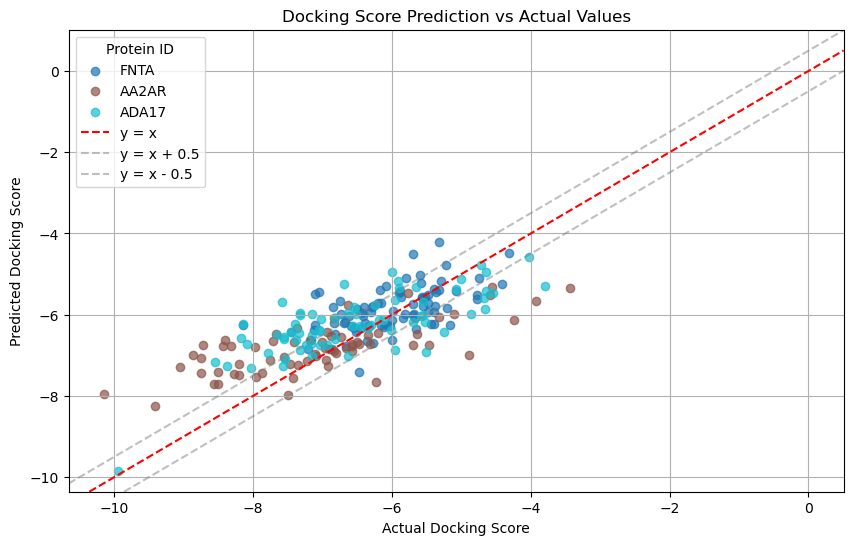

In [53]:
top_3_proteins = result_train_df.groupby('Protein_ID').size().sort_values(ascending=False).head(3).index
top_3_proteins_df = result_train_df[result_train_df['Protein_ID'].isin(top_3_proteins)]
plot_docking_scores_vs_predictions(top_3_proteins_df, ds_reg_output_dir, filename="docking_score_top_3_proteins_train_plot.png")